# Preparation

In [2]:
label_columns = ['Prolongation', 'Block', 'SoundRep', 
                 'WordRep', 'DifficultToUnderstand', 'Interjection',
                 'NoStutteredWords', 'NaturalPause']

In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
import feature_extractor as fe
from tqdm import tqdm

def remove_unwanted_rows(df, column, value):
    return df[df[column] != value]

def generate_clip_paths(df, base_path):
    def path_for_row(row):
        folder = Path(base_path) / row['Show'] / str(int(row['EpId']))
        filename = f"{row['Show']}_{int(row['EpId'])}_{int(row['ClipId'])}.wav"
        return str(folder / filename)
    
    df['ClipPath'] = df.apply(path_for_row, axis=1)
    return df

base_path = Path(r"C:\Users\ojmar\Documents\Uni\Synoptic Project\StammerScore\AudioFiles\clips")

df = pd.read_csv(Path(r"C:\Users\ojmar\Documents\Uni\Synoptic Project\StammerScore\Data\CSVs\SEP-28k_labels.csv"))

columns_to_binarize = ['Unsure', 'PoorAudioQuality', 'Prolongation', 'Block', 'SoundRep', 
                       'WordRep', 'DifficultToUnderstand', 'Interjection', 'NoStutteredWords', 
                       'NaturalPause', 'Music', 'NoSpeech']

# Apply binarization
for column in columns_to_binarize:
    df[column] = (df[column] >= 2).astype(int)

# Filter out rows where any of 'NoSpeech', 'Music', 'Unsure', or 'PoorAudioQuality' is 1
filtered_df = df[(df['NoSpeech'] == 0) & (df['Music'] == 0) & (df['Unsure'] == 0) & (df['PoorAudioQuality'] == 0)]

filtered_df = remove_unwanted_rows(filtered_df, 'Show', 'StrongVoices')
filtered_df = generate_clip_paths(filtered_df, base_path)

labels = filtered_df[label_columns].values

labels_df = pd.DataFrame(labels, columns=label_columns)

features = np.array([fe.load_audio_and_extract_features(path, 'advanced') for path in tqdm(filtered_df['ClipPath'], desc="Extracting features")])

features_df = pd.DataFrame(features)
features_and_labels = pd.concat([features_df, labels_df], axis=1)

features_and_labels.to_csv(Path(r'ML Models\features_labels_filtered_advanced.csv'), index=False)

Extracting features: 100%|██████████| 24786/24786 [04:14<00:00, 97.49it/s] 


In [15]:
labels_df.to_csv(Path(r'labels.csv'), index=False)

In [11]:

labels_df = pd.DataFrame(labels, columns=['Prolongation', 'Block', 'SoundRep', 
                                          'WordRep', 'DifficultToUnderstand', 'Interjection',
                                          'NoStutteredWords', 'NaturalPause'])
features_and_labels = pd.concat([features_df, labels_df], axis=1)


features_and_labels.to_csv(Path(r'ML Models\features_labels_filtered_advanced.csv'), index=False)

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import model_trainer
from sklearn.model_selection import train_test_split
from joblib import dump
from pathlib import Path

features_and_labels = pd.read_csv(Path(r'ML Models\features_labels_filtered_advanced.csv'))
labels = features_and_labels[label_columns].values
features = features_and_labels.drop(columns=label_columns).values

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

run_name = "Multi-Label"
scaler_path = Path(f'ML Models\\{run_name}\\scaler.joblib')
model_path = Path(f'ML Models\\{run_name}\\model.joblib')

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
dump(scaler, scaler_path)

model_trainer.train_and_evaluate_multi_label_gpu_optimized_balanced(X_train, X_test, y_train, y_test, model_path)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_parallel_backends.py", line 273, in _wrap_func_call
    return func()
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 589, in __call__
    return [func(*args, **kwargs)
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 589, in <listcomp>
    return [func(*args, **kwargs)
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py", line 129, in __call__
    return self.function(*args, **kwargs)
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multioutput.py", line 61, in _fit_estimator
    estimator.fit(X, y, **fit_params)
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py", line 1187, in fit
    super().fit(
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py", line 885, in fit
    self._Booster = train(
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py", line 286, in train
    cb(callback.CallbackEnv(model=booster,
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\callback.py", line 397, in __call__
    self._init(env)
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\callback.py", line 318, in _init
    raise ValueError(
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multioutput.py", line 537, in fit
    super().fit(X, Y, sample_weight=sample_weight, **fit_params)
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multioutput.py", line 272, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py", line 67, in __call__
    return super().__call__(iterable_with_config)
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 1952, in __call__
    return output if self.return_generator else list(output)
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 1595, in _get_outputs
    yield from self._retrieve()
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 1699, in _retrieve
    self._raise_error_fast()
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 1734, in _raise_error_fast
    error_job.get_result(self.timeout)
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 736, in get_result
    return self._return_or_raise()
  File "c:\Users\ojmar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py", line 754, in _return_or_raise
    raise self._result
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


Optimized Model Accuracy with LightGBM (GPU): 0.3417


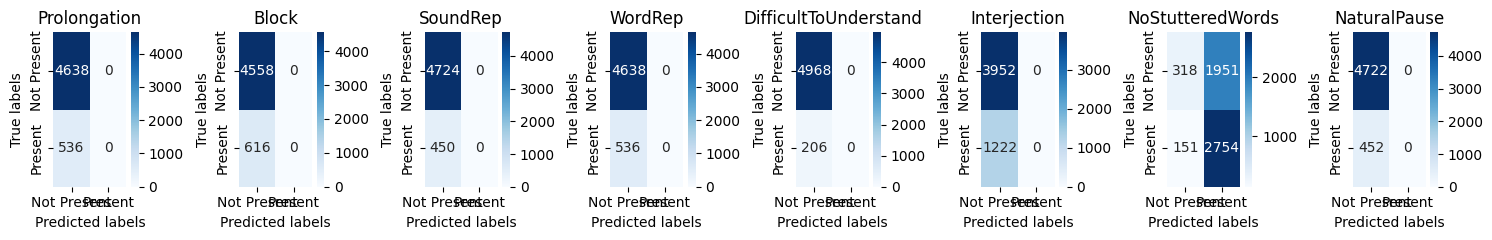

In [10]:
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix_for_each_label(y_true, y_pred, label_columns):
    """Plot confusion matrix for each label in multi-label predictions."""
    num_labels = y_true.shape[1]
    
    fig, axes = plt.subplots(nrows=1, ncols=num_labels, figsize=(15, 2.5), dpi=100)
    
    for i in range(num_labels):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        sns.heatmap(cm, annot=True, fmt='g', ax=axes[i], cmap='Blues')
        axes[i].set_title(label_columns[i])
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')
        axes[i].xaxis.set_ticklabels(['Not Present', 'Present'])
        axes[i].yaxis.set_ticklabels(['Not Present', 'Present'])
    
    plt.tight_layout()
    plt.show()

run_name = "Multi-Label"

scaler_path = Path(f'ML Models\\{run_name}\\scaler.joblib')
model_path = Path(f'ML Models\\{run_name}\\model.joblib')

model = joblib.load(model_path)
scaler = joblib.load(scaler_path)


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Optimized Model Accuracy with LightGBM (GPU): {accuracy:.4f}')

plot_confusion_matrix_for_each_label(y_test, y_pred, label_columns)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, hamming_loss

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42), n_jobs=-1)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Hamming Loss: {hamming}")


Accuracy: 0.30247390800154617
Hamming Loss: 0.1459702357943564
